In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

# WiDS Datathon 2025: ADHD and Sex Prediction

**Goal:** Build a multi-outcome model to predict:
1. ADHD diagnosis (ADHD_Outcome: 0=Other/None, 1=ADHD)
2. Sex (Sex_F: 0=Male, 1=Female)

**Note:** Female ADHD cases are weighted 2x in evaluation

## Data Loading and Preprocessing

In [4]:
# Update these paths to your data location
base_path = "/Users/ashly/Desktop/widsdata"
train_cat = pd.read_csv(os.path.join(base_path, 'TRAIN_CATEGORICAL_METADATA_new.csv'))
train_fcm = pd.read_csv(os.path.join(base_path, 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv'))
train_quant = pd.read_csv(os.path.join(base_path, 'TRAIN_QUANTITATIVE_METADATA_new.csv'))

# Load the training solutions file
train_solution = pd.read_csv("C:/Users/ashly/Desktop/widsdata/TRAINING_SOLUTIONS.csv")
# Verify the contents
print("Training solutions columns:", train_solution.columns.tolist())
print("\nFirst few rows of training solutions:")
print(train_solution.head())

# Display initial shapes
print("Initial data shapes:")
print(f"Categorical data: {train_cat.shape}")
print(f"FCM data: {train_fcm.shape}")
print(f"Quantitative data: {train_quant.shape}")

Training solutions columns: ['participant_id', 'ADHD_Outcome', 'Sex_F']

First few rows of training solutions:
  participant_id  ADHD_Outcome  Sex_F
0   UmrK0vMLopoR             1      1
1   CPaeQkhcjg7d             1      0
2   Nb4EetVPm3gs             1      0
3   p4vPhVu91o4b             1      1
4   M09PXs7arQ5E             1      1
Initial data shapes:
Categorical data: (1213, 10)
FCM data: (1213, 19901)
Quantitative data: (1213, 19)


In [5]:
# Categorical Data Overview
train_cat.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [6]:
# Functional Connectome Matrices Overview
train_fcm.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


In [7]:
# Quantitative Data Overview
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [8]:
# Data Merging
    # Merge the three datasets using participant_id

# First merge: Categorical and FCM data
merged_data = pd.merge(train_cat, train_fcm, on='participant_id', how='inner')
print(f"After first merge: {merged_data.shape}")

# Second merge: Add quantitative data
merged_data = pd.merge(merged_data, train_quant, on='participant_id', how='inner')
print(f"After second merge: {merged_data.shape}")

# Display Merged Data Overview
merged_data.head()

After first merge: (1213, 19910)
After second merge: (1213, 19928)


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [9]:
# Merge solutions with our feature data
merged_data_with_targets = pd.merge(
    merged_data, 
    train_solution[['participant_id', 'ADHD_Outcome', 'Sex_F']], 
    on='participant_id',
    how='inner'
)

analysis_data = pd.merge(
        merged_data,
        train_solution[['participant_id', 'ADHD_Outcome', 'Sex_F']],
        on='participant_id',
        how='inner'
    )

## Data Exploration and Verification
Check for missing values and data distribution

In [11]:
# Check missing values
missing_values = merged_data.isnull().sum()
missing_percentages = (missing_values / len(merged_data)) * 100

# Display columns with missing values and their percentages
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_percentages
})
missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values('Percentage Missing', ascending=False)

print("Columns with missing values:")
print(missing_info)

Columns with missing values:
                                  Missing Values  Percentage Missing
MRI_Track_Age_at_Scan                        360           29.678483
Barratt_Barratt_P2_Occ                       222           18.301731
Barratt_Barratt_P2_Edu                       198           16.323166
PreInt_Demos_Fam_Child_Race                   54            4.451772
PreInt_Demos_Fam_Child_Ethnicity              43            3.544930
Barratt_Barratt_P1_Occ                        31            2.555647
ColorVision_CV_Score                          23            1.896125
Barratt_Barratt_P1_Edu                        15            1.236603
EHQ_EHQ_Total                                 13            1.071723
APQ_P_APQ_P_PM                                12            0.989283
APQ_P_APQ_P_PP                                12            0.989283
APQ_P_APQ_P_OPD                               12            0.989283
APQ_P_APQ_P_INV                               12            0.989283
APQ_P

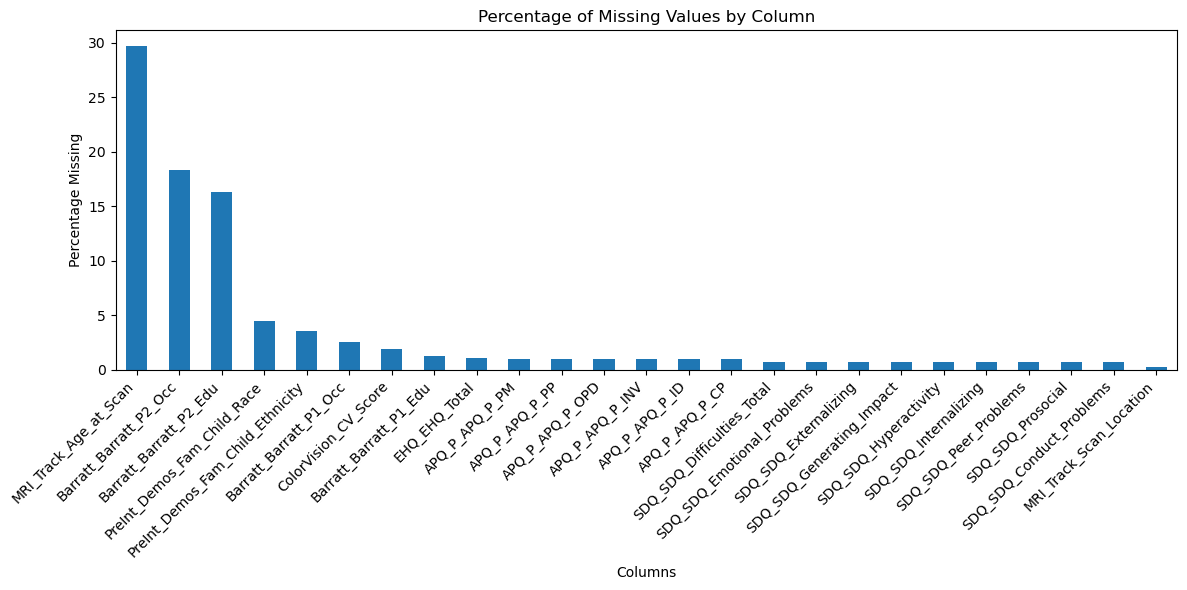

In [12]:
# Visualize missing values
plt.figure(figsize=(12, 6))
missing_info['Percentage Missing'].plot(kind='bar')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
# --- Handle Missing Values ---
# Option 1: Drop columns with high percentage of missing values
high_missing_threshold = 10  # 30% threshold
columns_to_drop = missing_info[missing_info['Percentage Missing'] > high_missing_threshold].index.tolist()

print(f"\nDropping {len(columns_to_drop)} columns with more than {high_missing_threshold}% missing values:")
print(columns_to_drop)

merged_data_cleaned = merged_data.drop(columns=columns_to_drop)


Dropping 3 columns with more than 10% missing values:
['MRI_Track_Age_at_Scan', 'Barratt_Barratt_P2_Occ', 'Barratt_Barratt_P2_Edu']


In [14]:
def analyze_correlations(data, target_col, n_features=10):
    """
    Analyze and visualize correlations with target variable
    """
    # Handle missing values in numeric columns
    numeric_data = data.select_dtypes(include=[np.number])
    numeric_data = numeric_data.fillna(numeric_data.median())
    
    # Calculate correlations
    correlations = numeric_data.corrwith(numeric_data[target_col])
    correlations = correlations.drop(target_col)  # Remove self-correlation
    correlations = correlations.sort_values(ascending=False)
    
    # Visualize top positive and negative correlations
    plt.figure(figsize=(12, 6))
    
    # Select top and bottom correlations
    top_bottom_corr = pd.concat([
        correlations.head(n_features),
        correlations.tail(n_features)
    ])
    
    # Create barplot
    sns.barplot(x=top_bottom_corr.values, 
                y=top_bottom_corr.index, 
                palette="coolwarm")
    plt.title(f"Top {n_features} Positive and Negative Correlations with {target_col}")
    plt.xlabel("Correlation Coefficient")
    plt.tight_layout()
    plt.show()
    
    return correlations

In [15]:
def analyze_mutual_information(data, target_col, n_features=20):
    """
    Analyze mutual information between features and target
    """
    # Prepare data
    X = data.copy()
    y = X.pop(target_col)
    
    # Handle missing values
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
    
    # Handle categorical columns
    for colname in X.select_dtypes("object"):
        X[colname] = X[colname].fillna(X[colname].mode()[0])
        X[colname], _ = X[colname].factorize()
    
    # Calculate MI scores
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    # Visualize top MI scores
    plt.figure(figsize=(12, 6))
    sns.barplot(x=mi_scores.head(n_features).values,
                y=mi_scores.head(n_features).index,
                palette="viridis")
    plt.title(f"Top {n_features} Features by Mutual Information with {target_col}")
    plt.xlabel("Mutual Information Score")
    plt.tight_layout()
    plt.show()
    
    return mi_scores


Calculating mutual information for ADHD prediction...


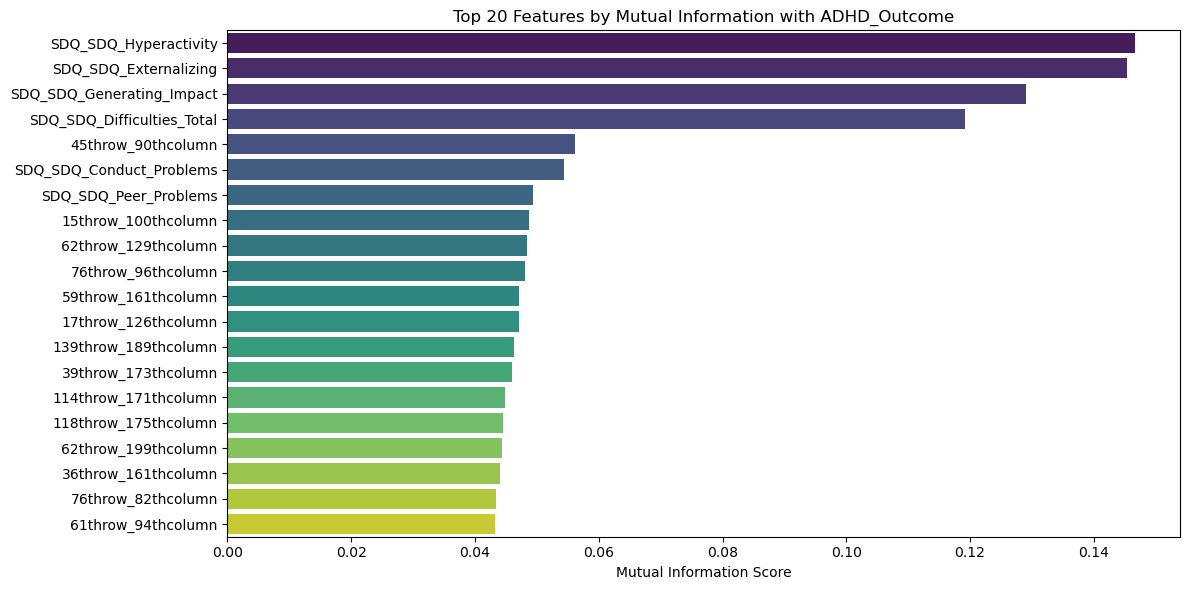


Top 10 Mutual Information scores for ADHD_Outcome:
SDQ_SDQ_Hyperactivity         0.146585
SDQ_SDQ_Externalizing         0.145414
SDQ_SDQ_Generating_Impact     0.129093
SDQ_SDQ_Difficulties_Total    0.119152
45throw_90thcolumn            0.056212
SDQ_SDQ_Conduct_Problems      0.054431
SDQ_SDQ_Peer_Problems         0.049397
15throw_100thcolumn           0.048791
62throw_129thcolumn           0.048405
76throw_96thcolumn            0.048044
Name: MI Scores, dtype: float64

Calculating mutual information for Sex prediction...


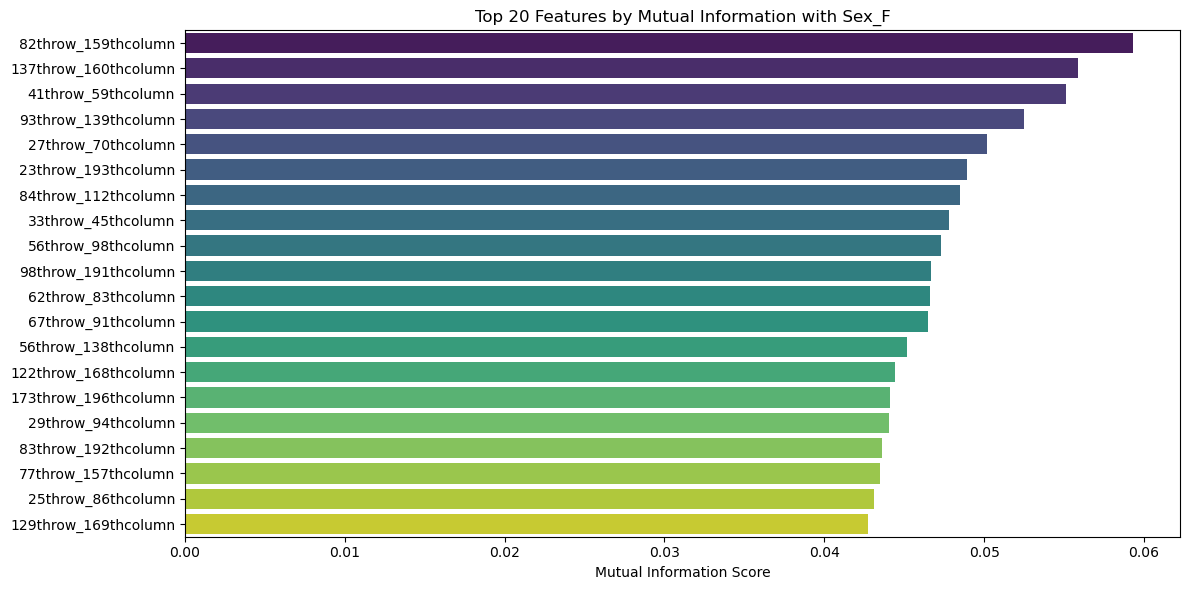


Top 10 Mutual Information scores for Sex_F:
82throw_159thcolumn     0.059288
137throw_160thcolumn    0.055848
41throw_59thcolumn      0.055118
93throw_139thcolumn     0.052513
27throw_70thcolumn      0.050183
23throw_193thcolumn     0.048899
84throw_112thcolumn     0.048514
33throw_45thcolumn      0.047773
56throw_98thcolumn      0.047273
98throw_191thcolumn     0.046663
Name: MI Scores, dtype: float64


In [16]:
# Analyze ADHD mutual information
print("\nCalculating mutual information for ADHD prediction...")
adhd_mi = analyze_mutual_information(analysis_data, 'ADHD_Outcome')
print("\nTop 10 Mutual Information scores for ADHD_Outcome:")
print(adhd_mi.head(10))

# Analyze Sex mutual information
print("\nCalculating mutual information for Sex prediction...")
sex_mi = analyze_mutual_information(analysis_data, 'Sex_F')
print("\nTop 10 Mutual Information scores for Sex_F:")
print(sex_mi.head(10))


Analyzing Sex prediction...


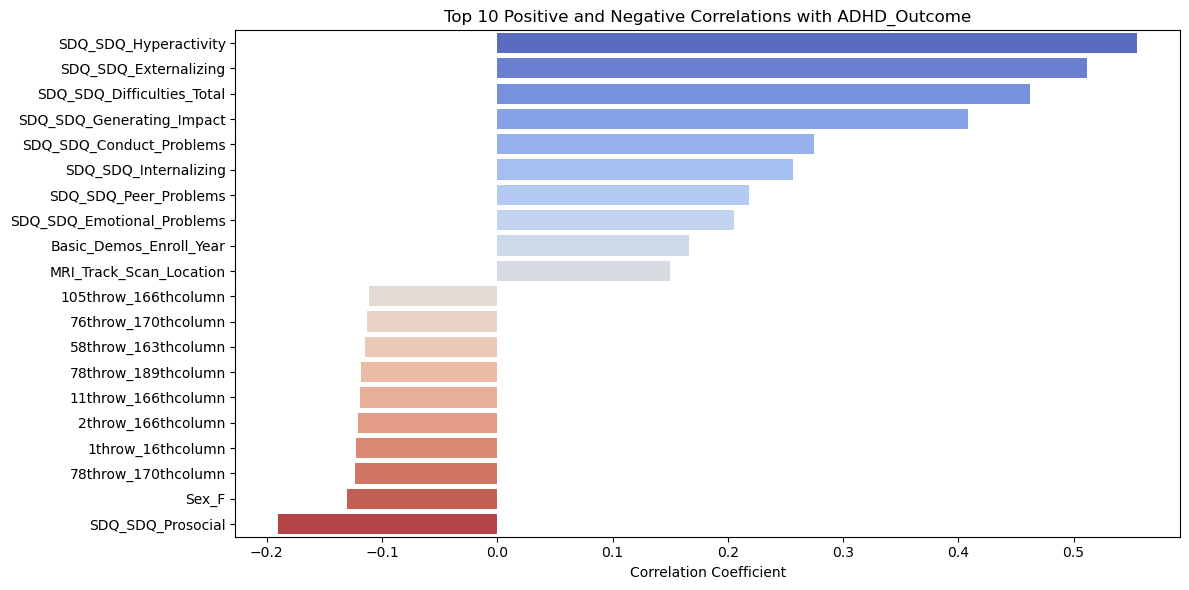


Top 10 correlations with ADHD_Outcome:
SDQ_SDQ_Hyperactivity         0.554996
SDQ_SDQ_Externalizing         0.511544
SDQ_SDQ_Difficulties_Total    0.462403
SDQ_SDQ_Generating_Impact     0.408330
SDQ_SDQ_Conduct_Problems      0.274289
SDQ_SDQ_Internalizing         0.256546
SDQ_SDQ_Peer_Problems         0.218593
SDQ_SDQ_Emotional_Problems    0.204939
Basic_Demos_Enroll_Year       0.166252
MRI_Track_Scan_Location       0.149442
dtype: float64

Bottom 10 correlations with ADHD_Outcome:
105throw_166thcolumn   -0.111699
76throw_170thcolumn    -0.112919
58throw_163thcolumn    -0.115072
78throw_189thcolumn    -0.118449
11throw_166thcolumn    -0.118818
2throw_166thcolumn     -0.120729
1throw_16thcolumn      -0.122222
78throw_170thcolumn    -0.123331
Sex_F                  -0.130836
SDQ_SDQ_Prosocial      -0.189930
dtype: float64


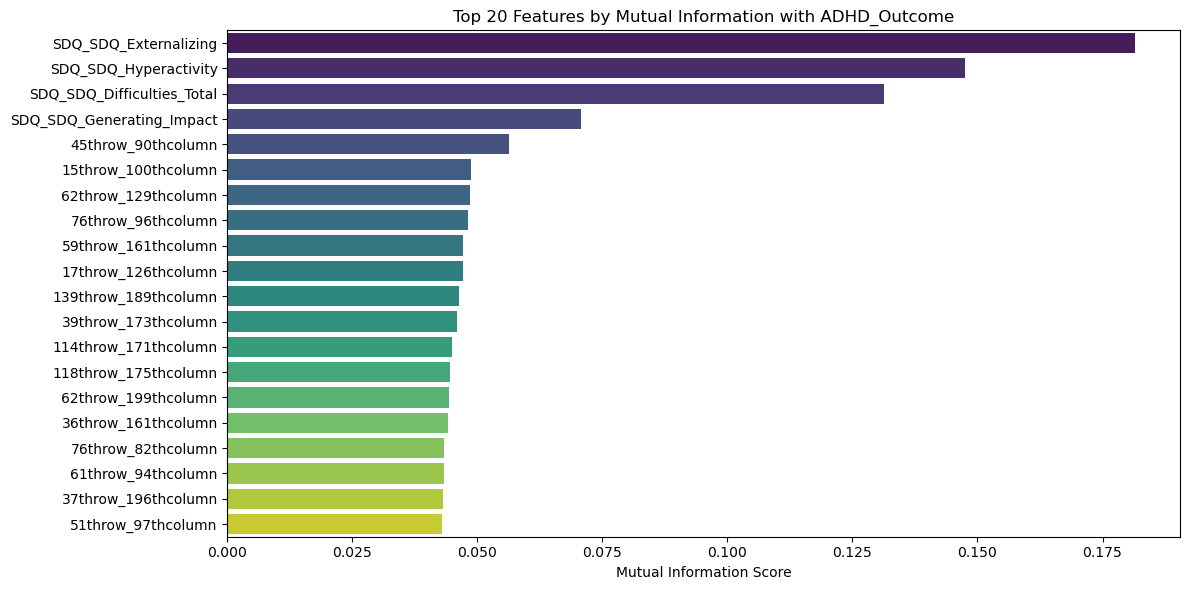


Top 10 Mutual Information scores for ADHD_Outcome:
SDQ_SDQ_Externalizing         0.181428
SDQ_SDQ_Hyperactivity         0.147523
SDQ_SDQ_Difficulties_Total    0.131329
SDQ_SDQ_Generating_Impact     0.070762
45throw_90thcolumn            0.056212
15throw_100thcolumn           0.048791
62throw_129thcolumn           0.048405
76throw_96thcolumn            0.048044
59throw_161thcolumn           0.047177
17throw_126thcolumn           0.047046
Name: MI Scores, dtype: float64


In [17]:
# Run the analysis

# Remove participant_id for analysis
print("\nAnalyzing Sex prediction...")

# Correlation analysis for ADHD
adhd_correlations = analyze_correlations(analysis_data, 'ADHD_Outcome')
print("\nTop 10 correlations with ADHD_Outcome:")
print(adhd_correlations.head(10))
print("\nBottom 10 correlations with ADHD_Outcome:")
print(adhd_correlations.tail(10))

# Mutual Information analysis for ADHD
adhd_mi = analyze_mutual_information(analysis_data, 'ADHD_Outcome')
print("\nTop 10 Mutual Information scores for ADHD_Outcome:")
print(adhd_mi.head(10))

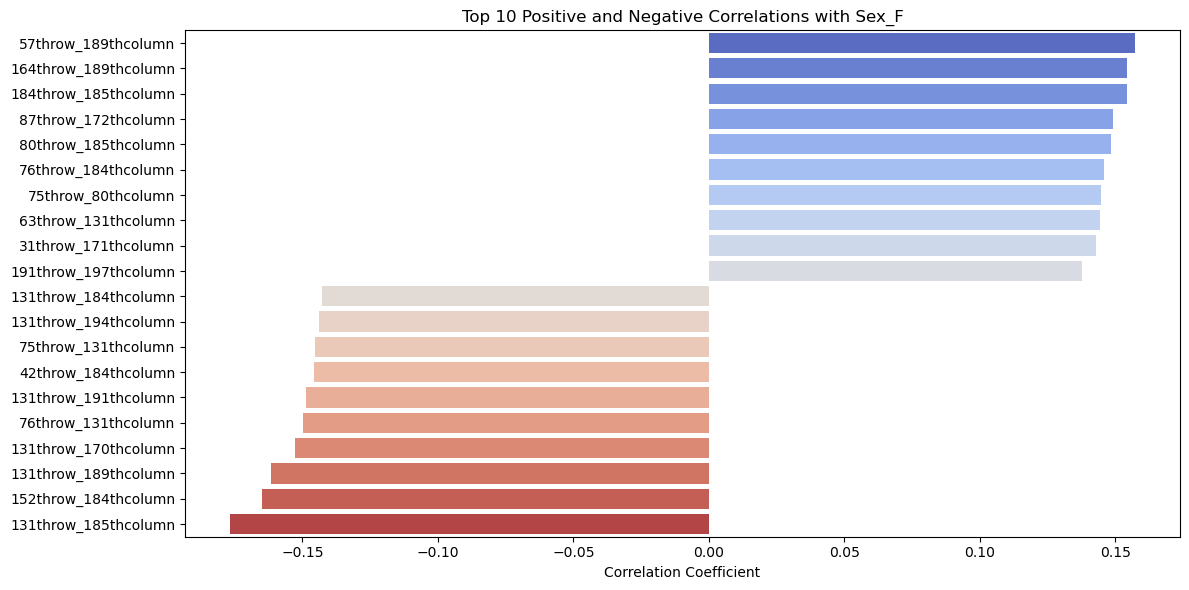


Top 10 correlations with Sex_F:
57throw_189thcolumn     0.157162
164throw_189thcolumn    0.154435
184throw_185thcolumn    0.154399
87throw_172thcolumn     0.149252
80throw_185thcolumn     0.148402
76throw_184thcolumn     0.145770
75throw_80thcolumn      0.144709
63throw_131thcolumn     0.144277
31throw_171thcolumn     0.143003
191throw_197thcolumn    0.137868
dtype: float64

Bottom 10 correlations with Sex_F:
131throw_184thcolumn   -0.142884
131throw_194thcolumn   -0.144002
75throw_131thcolumn    -0.145423
42throw_184thcolumn    -0.145723
131throw_191thcolumn   -0.148504
76throw_131thcolumn    -0.149693
131throw_170thcolumn   -0.152527
131throw_189thcolumn   -0.161591
152throw_184thcolumn   -0.164750
131throw_185thcolumn   -0.176659
dtype: float64


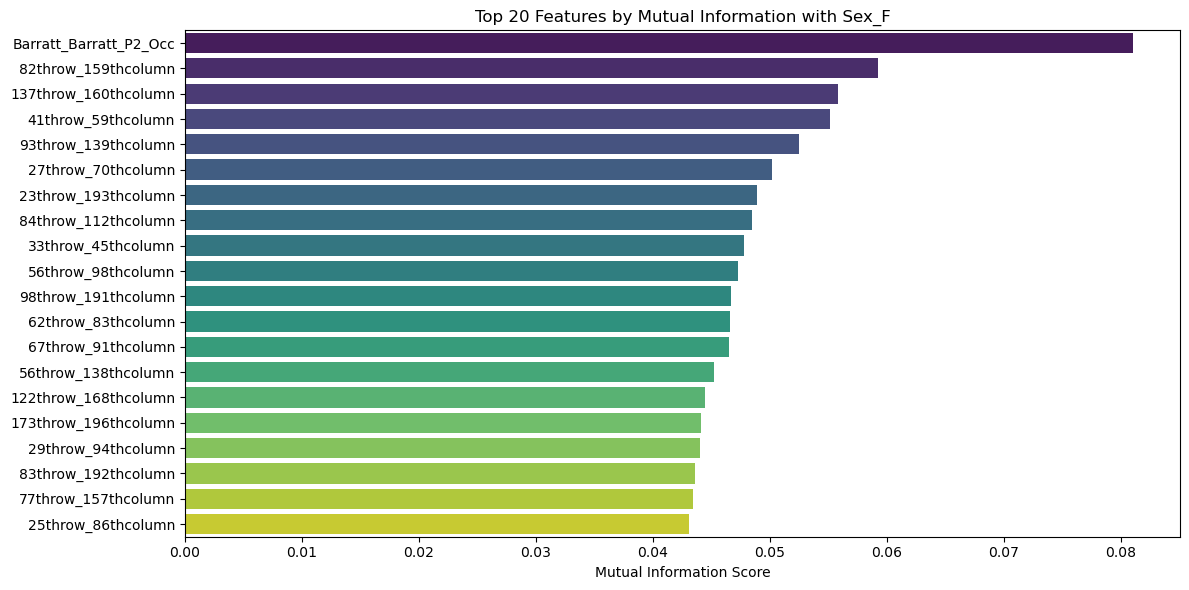


Top 10 Mutual Information scores for Sex_F:
Barratt_Barratt_P2_Occ    0.081020
82throw_159thcolumn       0.059288
137throw_160thcolumn      0.055848
41throw_59thcolumn        0.055118
93throw_139thcolumn       0.052513
27throw_70thcolumn        0.050183
23throw_193thcolumn       0.048899
84throw_112thcolumn       0.048514
33throw_45thcolumn        0.047773
56throw_98thcolumn        0.047273
Name: MI Scores, dtype: float64


In [18]:
# Correlation analysis for Sex
sex_correlations = analyze_correlations(analysis_data, 'Sex_F')
print("\nTop 10 correlations with Sex_F:")
print(sex_correlations.head(10))
print("\nBottom 10 correlations with Sex_F:")
print(sex_correlations.tail(10))

# Mutual Information analysis for Sex
sex_mi = analyze_mutual_information(analysis_data, 'Sex_F')
print("\nTop 10 Mutual Information scores for Sex_F:")
print(sex_mi.head(10))

In [19]:
# Save results
results = pd.DataFrame({
    'ADHD_correlation': adhd_correlations,
    'ADHD_mutual_info': adhd_mi,
    'Sex_correlation': sex_correlations,
    'Sex_mutual_info': sex_mi})

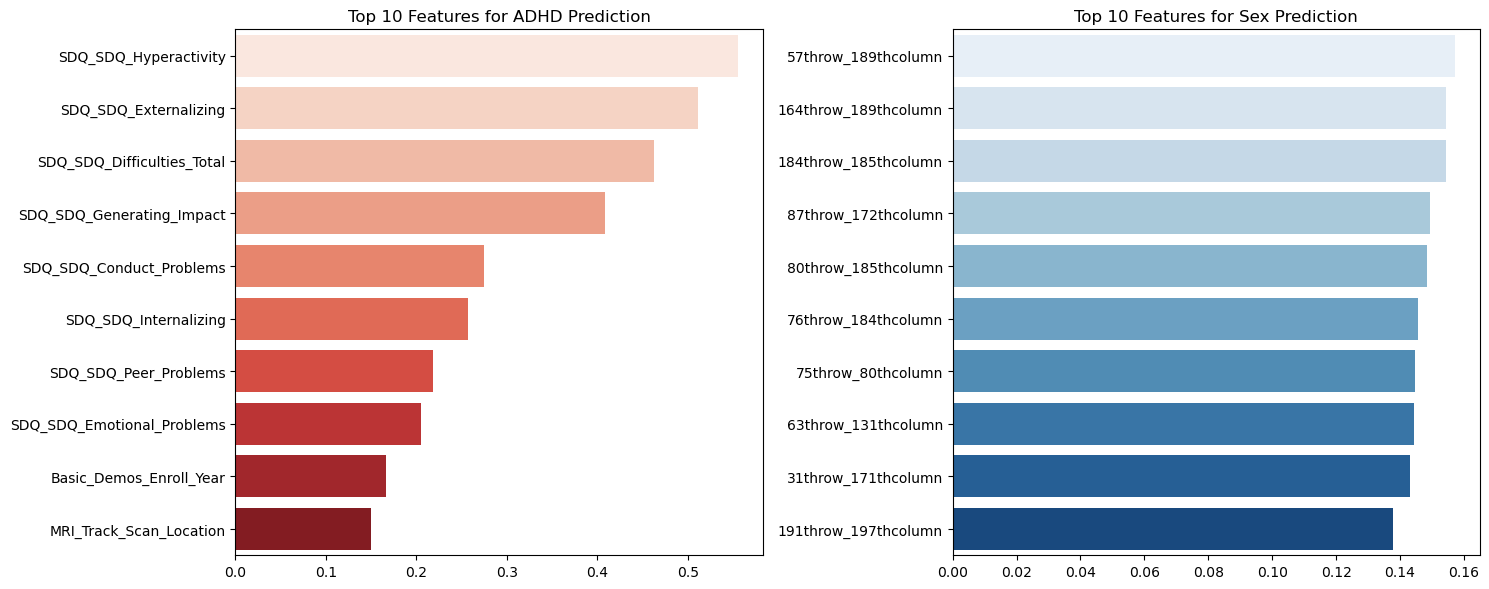

In [20]:
# Additional visualization: Compare top features for both targets
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=adhd_correlations.head(10).values,
            y=adhd_correlations.head(10).index,
            palette="Reds")
plt.title("Top 10 Features for ADHD Prediction")

plt.subplot(1, 2, 2)
sns.barplot(x=sex_correlations.head(10).values,
            y=sex_correlations.head(10).index,
            palette="Blues")
plt.title("Top 10 Features for Sex Prediction")

plt.tight_layout()
plt.show()

## Preprocessing Pipeline
Create preprocessing pipelines for numeric and categorical features

In [33]:
# Identify numeric and categorical features from X
def identify_feature_types(X):
    """
    Identify numeric and categorical features from the dataset
    """
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
    
    print("Feature type summary:")
    print(f"Number of numeric features: {len(numeric_features)}")
    print(f"Number of categorical features: {len(categorical_features)}")
    
    return numeric_features, categorical_features

In [43]:
# Create preprocessing pipelines
def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create preprocessing pipeline for both numeric and categorical features
    """
    # Numeric pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor
    
# Load and prepare data
try:
    # Separate features and targets
    target_cols = ['ADHD_Outcome', 'Sex_F']
    X = merged_data_with_targets.drop(columns=target_cols + ['participant_id'])
    y = merged_data_with_targets[target_cols]
    
    print("Initial data shapes:")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    
    # Identify feature types
    numeric_features, categorical_features = identify_feature_types(X)
    
    # Create and fit preprocessor
    preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)
    
    # Fit and transform the data
    X_processed = preprocessor.fit_transform(X)
    
    print("\nPreprocessing results:")
    print("Original feature shape:", X.shape)
    print("Processed feature shape:", X_processed.shape)
    
    # Verify preprocessing results
    print("\nPreprocessing summary:")
    print("Missing values after preprocessing:", np.isnan(X_processed).sum())
    print("Infinite values after preprocessing:", np.isinf(X_processed).sum())
    
    # Display sample of processed data
    # Get feature names after preprocessing
    processed_feature_names = (
        numeric_features +
        preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    )
    
    X_processed_df = pd.DataFrame(
        X_processed,
        columns=processed_feature_names
    )
    
    print("\nProcessed data preview:")
    print(X_processed_df.head())
    
    # Basic statistics of processed features
    print("\nProcessed features statistics:")
    print(X_processed_df.describe().round(2))

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    print(traceback.format_exc())

Initial data shapes:
X shape: (1213, 19927)
y shape: (1213, 2)
Feature type summary:
Number of numeric features: 19927
Number of categorical features: 0

Preprocessing results:
Original feature shape: (1213, 19927)
Processed feature shape: (1213, 19927)

Preprocessing summary:
Missing values after preprocessing: 0
Infinite values after preprocessing: 0
An error occurred: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
Traceback (most recent call last):
  File "C:\Users\ashly\AppData\Local\Temp\ipykernel_31104\4196472582.py", line 60, in <module>
    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ashly\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py", line 1101, in get_feature_names_out
    check_is_fitted(self)
  F

## Feature Names and Final Dataset
Create meaningful feature names and organize the processed data

In [45]:
def get_feature_names(preprocessor, numeric_features, categorical_features):
    """
    Get feature names after preprocessing
    """
    # Get numeric feature names (unchanged)
    numeric_names = numeric_features
    
    # Get categorical feature names after one-hot encoding
    if categorical_features:
        categorical_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    else:
        categorical_names = []
    
    # Combine all feature names
    feature_names = np.concatenate([numeric_names, categorical_names])
    
    return feature_names

# Get feature names
feature_names = get_feature_names(preprocessor, numeric_features, categorical_features)

# Create DataFrame with processed features
X_processed_df = pd.DataFrame(
    X_processed, 
    columns=feature_names
)

# Add target variables back
final_dataset = pd.concat([
    X_processed_df,
    y.reset_index(drop=True)
], axis=1)

print("Final dataset shape:", final_dataset.shape)
print("\nFeature names preview (first 10):")
print(feature_names[:10])

# Basic statistics of processed features
print("\nProcessed features statistics:")
print(X_processed_df.describe().round(2))

# Save feature names for later use
feature_names_dict = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'processed_features': feature_names.tolist()
}

Final dataset shape: (1213, 19929)

Feature names preview (first 10):
['Basic_Demos_Enroll_Year' 'Basic_Demos_Study_Site'
 'PreInt_Demos_Fam_Child_Ethnicity' 'PreInt_Demos_Fam_Child_Race'
 'MRI_Track_Scan_Location' 'Barratt_Barratt_P1_Edu'
 'Barratt_Barratt_P1_Occ' 'Barratt_Barratt_P2_Edu'
 'Barratt_Barratt_P2_Occ' '0throw_1thcolumn']

Processed features statistics:
       Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
count                  1213.00                 1213.00   
mean                      0.00                   -0.00   
std                       1.00                    1.00   
min                      -2.36                   -0.89   
25%                      -0.58                   -0.89   
50%                       0.31                   -0.89   
75%                       1.20                    0.87   
max                       2.09                    1.75   

       PreInt_Demos_Fam_Child_Ethnicity  PreInt_Demos_Fam_Child_Race  \
count                           1213

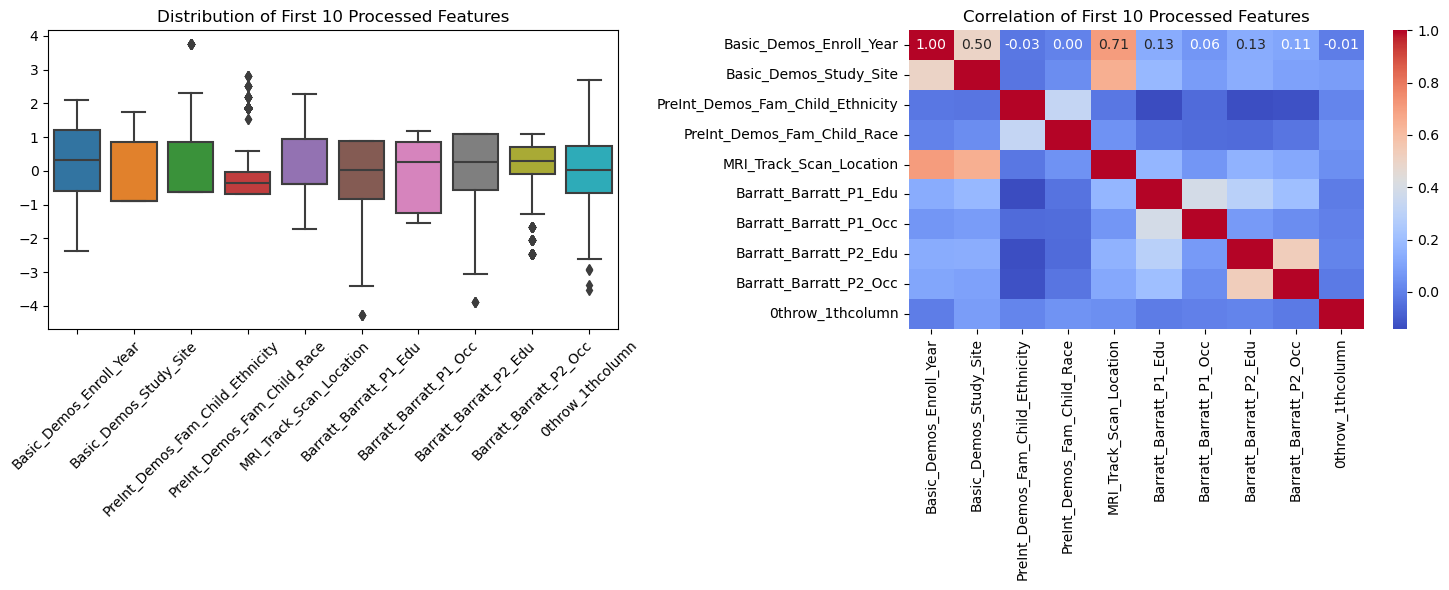

In [47]:
# Visualize feature distributions after preprocessing
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_processed_df[feature_names[:10]])
plt.title('Distribution of First 10 Processed Features')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.heatmap(X_processed_df[feature_names[:10]].corr(), 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm')
plt.title('Correlation of First 10 Processed Features')
plt.tight_layout()
plt.show()

In [49]:
# Create summary of final dataset
print("\nFinal Dataset Summary:")
print("=" * 50)
print(f"Total samples: {final_dataset.shape[0]}")
print(f"Total features: {final_dataset.shape[1] - 2}")  # subtract 2 for target columns
print(f"Target variables: {', '.join(target_cols)}")
print("\nTarget distributions:")
for target in target_cols:
    print(f"\n{target}:")
    print(final_dataset[target].value_counts(normalize=True).round(3))



Final Dataset Summary:
Total samples: 1213
Total features: 19927
Target variables: ADHD_Outcome, Sex_F

Target distributions:

ADHD_Outcome:
ADHD_Outcome
1    0.685
0    0.315
Name: proportion, dtype: float64

Sex_F:
Sex_F
0    0.657
1    0.343
Name: proportion, dtype: float64


## Quality Checks and Validation
Perform final checks on the processed dataset

In [51]:
def validate_processed_dataset(data, feature_names, target_cols):
    """
    Perform validation checks on processed dataset
    """
    print("Dataset Validation Checks:")
    print("=" * 50)
    
    # Check for missing values
    missing = data.isnull().sum()
    if missing.sum() > 0:
        print("\nWarning: Missing values found:")
        print(missing[missing > 0])
    else:
        print("\n✓ No missing values")
    
    # Check for infinite values
    if np.isinf(data.select_dtypes(include=[np.number])).sum().sum() > 0:
        print("\nWarning: Infinite values found")
    else:
        print("\n✓ No infinite values")
    
    # Check feature ranges
    print("\nFeature ranges:")
    print(data[feature_names].agg(['min', 'max']).T.head())
    
    # Check target variable integrity
    print("\nTarget variable checks:")
    for target in target_cols:
        print(f"\n{target}:")
        print("Unique values:", data[target].unique())
        print("Value counts:", data[target].value_counts())

# Run validation checks
validate_processed_dataset(final_dataset, feature_names, target_cols)

Dataset Validation Checks:

✓ No missing values

✓ No infinite values

Feature ranges:
                                       min       max
Basic_Demos_Enroll_Year          -2.363603  2.092490
Basic_Demos_Study_Site           -0.894385  1.749535
PreInt_Demos_Fam_Child_Ethnicity -0.613571  3.764441
PreInt_Demos_Fam_Child_Race      -0.676701  2.825714
MRI_Track_Scan_Location          -1.725654  2.276675

Target variable checks:

ADHD_Outcome:
Unique values: [1 0]
Value counts: ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

Sex_F:
Unique values: [0 1]
Value counts: Sex_F
0    797
1    416
Name: count, dtype: int64
